In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import pandas as pd
from pathlib import Path
from utils import *
from inception import *
from models import *
from ucr import *
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import fastai
from fastai.vision import *

In [3]:
DATAPATH = Path.cwd()/'Univariate_arff'

In [4]:
sorted(list(DATAPATH.iterdir()))

[PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/ACSF1'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/Adiac'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/AllGestureWiimoteX'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/AllGestureWiimoteY'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/AllGestureWiimoteZ'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/ArrowHead'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/BME'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/Beef'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/BeetleFly'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/BirdChicken'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/CBF'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/C

In [5]:
task = 'Adiac'
df_train, df_test = load_df(DATAPATH, task)

Loading files from: /home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/Adiac


In [6]:
num_classes = df_train.target.nunique(); num_classes

37

# DL

In [7]:
x_train, y_train, x_test, y_test = process_dfs(df_train, df_test)

In [8]:
x_train.shape, x_test.shape

((390, 176), (391, 176))

In [9]:
tr_ds, val_ds = to_TDS(x_train, y_train), to_TDS(x_test, y_test)

In [10]:
db = create_databunch(tr_ds, val_ds, 32)

Testing dims at input/output

In [11]:
for tx, ty in db.train_dl:
    print(tx.shape, ty.shape)

torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([32, 1, 176]) torch.Size([32])
torch.Size([6, 1, 176]) torch.Size([6])


## Inception Time

In [12]:
model = create_inception(1, num_classes).cuda()

In [13]:
# model = create_inception_resnet(1, num_classes, kss=[39, 19, 9], conv_sizes=[128, 128, 256]).cuda()

In [14]:
model

Sequential(
  (0): InceptionModule(
    (convs): ModuleList(
      (0): Conv1d(1, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
      (1): Conv1d(1, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
      (2): Conv1d(1, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
    )
    (conv_bottle): Sequential(
      (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (1): Conv1d(1, 32, kernel_size=(1,), stride=(1,), bias=False)
    )
    (bn_relu): Sequential(
      (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
    )
  )
  (1): SequentialEx(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(128, 128, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv1d(128, 128, k

In [15]:
model(tx).shape

torch.Size([6, 37])

In [17]:
learn_res = fastai.basic_train.Learner(db, 
                                       model, 
                                       loss_func = CrossEntropyFlat(), 
                                       metrics=[error_rate],
                                       wd=1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 1.74E-04


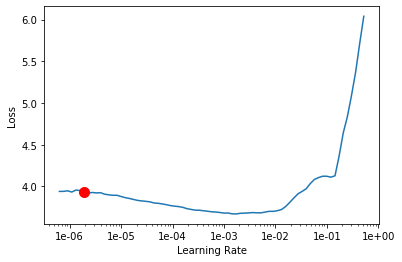

In [19]:
learn_res.lr_find(); learn_res.recorder.plot(suggestion=True)

In [20]:
learn_res.fit(40, 1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,3.840801,4.158364,0.953964,00:00
1,3.747856,3.733966,0.971867,00:00
2,3.707987,3.588137,0.951407,00:00
3,3.636826,3.489943,0.946292,00:00
4,3.544275,3.281200,0.915601,00:00
5,3.448336,3.153179,0.884910,00:00
6,3.325364,2.940802,0.820972,00:00
7,3.189197,2.954613,0.861893,00:00
8,3.064853,2.736009,0.823529,00:00
9,2.946997,2.480475,0.744246,00:00


In [18]:
p, t = learn_res.get_preds()

In [19]:
error_rate(p,t)

tensor(0.2558)

In [20]:
def get_cm(p, t): return confusion_matrix(t, p.softmax(dim=1).argmax(1))

Confusion Matrix

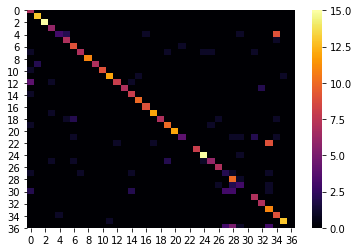

In [21]:
sns.heatmap(get_cm(p,t), cmap='inferno')